# **Import**
All necessary libraries for data manipulation and visualization are imported here.

In [1]:
# Import library
import pandas as pd
import numpy as np
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import seaborn as sns
import json

# **Load data**

### **Dataset Components**
**1. Transaction Data (transactions_data.csv)**
* Detailed transaction records.
* Features transaction types, amounts, and merchant information

**2. Card Information (cards_dat.csv)**
* Credit and debit card details
* Includes card limits, types, and activation dates
* Links to customer accounts via card_id

**3. User Data (users_data)**
* Demographic information about customers
* Account-related details

**4. Fraud Labels (train_fraud_labels.json)**
* Binary classification labels for transactions

**5. Merchant Category Codes (mcc_codes.json)**
* Standard classification codes for business types
* Industry-standard MCC codes with descriptions


In [2]:
# Load csv dataset
cards_df = pd.read_csv('../../data/cards_data.csv')
txn_df = pd.read_csv('../../data/transactions_data.csv')
user_df = pd.read_csv('../../data/users_data.csv')

# Load json dataset
with open("../../data/mcc_codes.json", encoding='utf8') as  json_file:
    mcc_codes = json.load(json_file)
mcc_codes_df = pd.DataFrame(mcc_codes.items(), columns=['mcc_code', 'description'])

with open("../../data/train_fraud_labels.json") as f:
    fraud_label = json.load(f)

fraud_label_df = pd.DataFrame(list(fraud_label["target"].items()), columns=["transaction_id", "fraud_label"])
print(fraud_label_df.head())


## **Data Cleaning and Transform**

### Cards Data

In [8]:
print(cards_df['card_type'].unique())

['Debit' 'Credit' 'Debit (Prepaid)']


In [3]:
print(cards_df.shape)

print(cards_df.info())

(6146, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6146 non-null   int64 
 1   client_id              6146 non-null   int64 
 2   card_brand             6146 non-null   object
 3   card_type              6146 non-null   object
 4   card_number            6146 non-null   int64 
 5   expires                6146 non-null   object
 6   cvv                    6146 non-null   int64 
 7   has_chip               6146 non-null   object
 8   num_cards_issued       6146 non-null   int64 
 9   credit_limit           6146 non-null   object
 10  acct_open_date         6146 non-null   object
 11  year_pin_last_changed  6146 non-null   int64 
 12  card_on_dark_web       6146 non-null   object
dtypes: int64(6), object(7)
memory usage: 624.3+ KB
None


**📊 Dataset Description:**

The `cards_dataset` contains *6,146 rows and 13 columns* about payment cards issued to clients, including card attributes, issuance history, credit limits, and security-related indicators.

***Column Description***

| Column Name | Data Type | Description |
|-------------|-----------|-------------|
| **id** | Integer | Unique identifier for each card record. |
| **client_id** | Integer | Unique identifier of the client who owns the card. |
| **card_brand** | String | Card network provider (e.g., Visa, Mastercard). |
| **card_type** | String | Type of card issued (e.g., Debit, Credit, Prepaid). |
| **card_number** | Integer | Masked or anonymized card number identifier. Used only for record uniqueness, not real card data. |
| **expires** | String / Date | Card expiration date in MM/YYYY format. |
| **cvv** | Integer | Card verification value (security code). Typically anonymized or synthetic for privacy. |
| **has_chip** | Boolean | Indicates whether the card has an EMV chip (`YES` / `NO`). |
| **num_cards_issued** | Integer | Number of cards issued to the client (including replacements and duplicates). |
| **credit_limit** | Float | Maximum credit limit assigned to the card account. |
| **acct_open_date** | String / Date | Date when the card account was first opened. |
| **year_pin_last_changed** | Integer | The most recent year the card PIN was changed, used to evaluate security hygiene. |
| **card_on_dark_web** | Boolean | Indicates whether the card information has been detected on dark web marketplaces (Yes/No). |



In [4]:
cards_df.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [5]:
cards_df['credit_limit'] = cards_df['credit_limit'].str.replace("$","").astype(float)
cards_df['credit_limit']

0       24295.0
1       21968.0
2       46414.0
3       12400.0
4          28.0
         ...   
6141     6900.0
6142     5700.0
6143     9200.0
6144    28074.0
6145    14400.0
Name: credit_limit, Length: 6146, dtype: float64

In [6]:
cards_df.describe(include = 'all')

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
count,6146.000000,6146.000000,6146,6146,6.146000e+03,6146,6146.000000,6146,6146.000000,6146.000000,6146,6146.000000,6146
unique,NaN,NaN,4,3,NaN,259,NaN,2,NaN,NaN,303,NaN,1
top,NaN,NaN,Mastercard,Debit,NaN,02/2020,NaN,YES,NaN,NaN,02/2020,NaN,No
freq,NaN,NaN,3209,3511,NaN,377,NaN,5500,NaN,NaN,607,NaN,6146
mean,3072.500000,994.939636,NaN,NaN,4.820426e+15,NaN,506.220794,NaN,1.503091,14347.493980,NaN,2013.436707,NaN
std,1774.341709,578.614626,NaN,NaN,1.328582e+15,NaN,289.431123,NaN,0.519191,12014.463884,NaN,4.270699,NaN
min,0.000000,0.000000,NaN,NaN,3.001055e+14,NaN,0.000000,NaN,1.000000,0.000000,NaN,2002.000000,NaN
25%,1536.250000,492.250000,NaN,NaN,4.486365e+15,NaN,257.000000,NaN,1.000000,7042.750000,NaN,2010.000000,NaN
50%,3072.500000,992.000000,NaN,NaN,5.108957e+15,NaN,516.500000,NaN,1.000000,12592.500000,NaN,2013.000000,NaN
75%,4608.750000,1495.000000,NaN,NaN,5.585237e+15,NaN,756.000000,NaN,2.000000,19156.500000,NaN,2017.000000,NaN


In [7]:
print(cards_df.isnull().sum())

id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64


In [8]:
# Check for duplicates
print(cards_df.duplicated().sum())

0


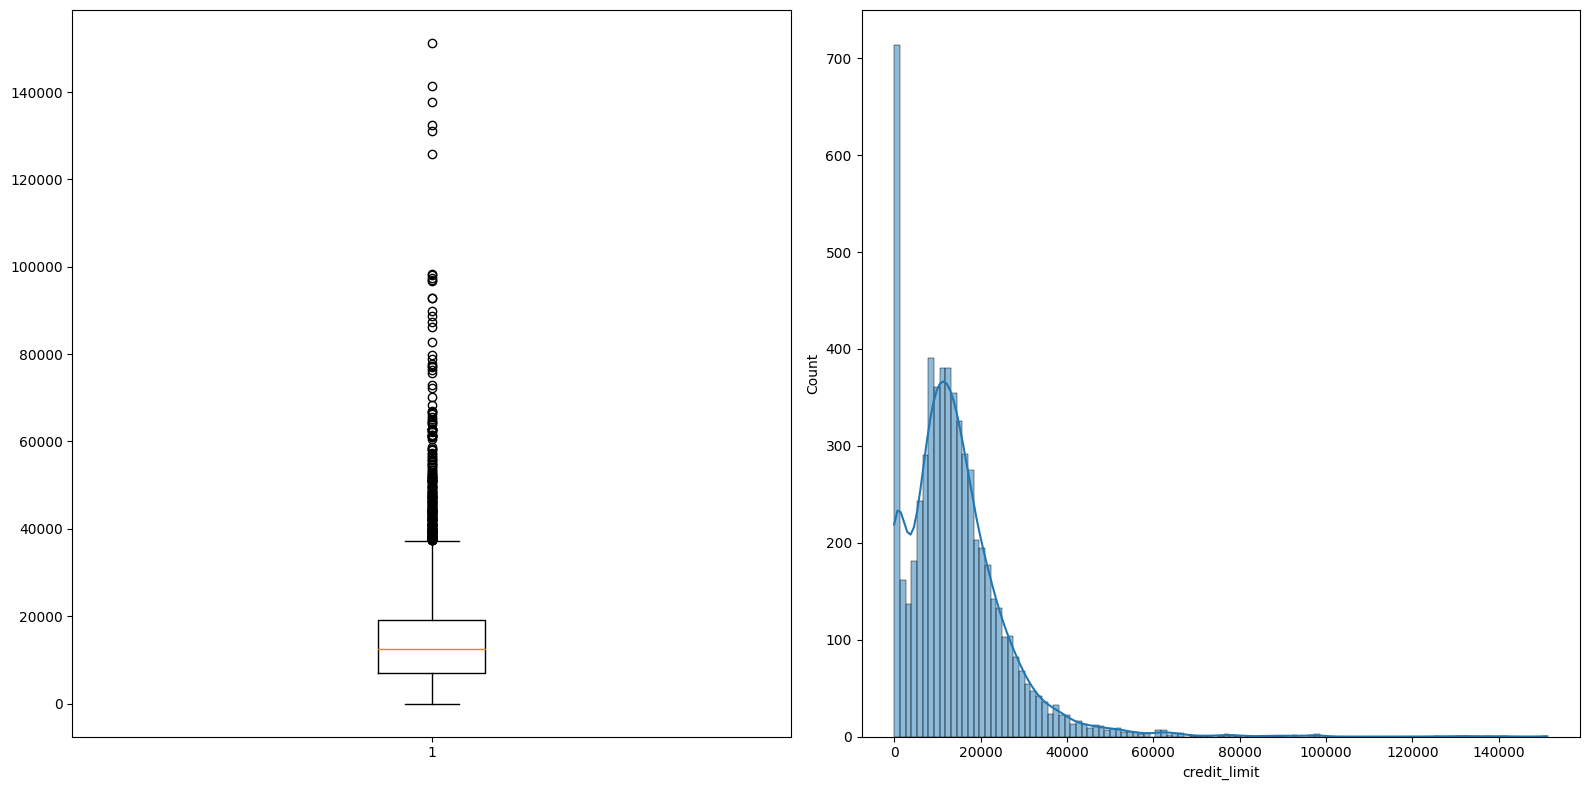

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].boxplot(cards_df['credit_limit'])

sns.histplot(cards_df['credit_limit'], kde=True, ax=axes[1])

plt.tight_layout()
plt.show()

After observing the boxplot and density distribution, we can see that:
- The credit limit distribution is right-skewed with several outliers.
- The distribution peaks around 10–15k. There is also a small peak near zero, which may be due to new customers with low credit limits. The right tail is very long, extending up to 140k, which likely represents VIP customers.

In general, the dataset reflects various customer segments. From a business
perspective, the outliers and fluctuations in credit limits are reasonable because
banks serve customers across different segments with different credit limits.
Therefore, at this stage, I will keep these outliers. These outliers will be handled
later if necessary.


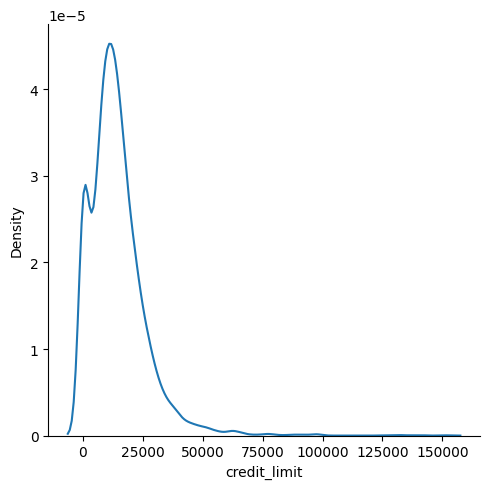

In [10]:
sns.displot(cards_df['credit_limit'], kind='kde')
plt.show()

In [11]:
# Number of clients
print(cards_df['client_id'].nunique())

# Check the number of card each client have
client_df = pd.DataFrame(cards_df.groupby('client_id')['id'].nunique())
client_df.rename(columns={'id':'card_count'}, inplace=True)
print(client_df.describe())

2000
        card_count
count  2000.000000
mean      3.073000
std       1.637379
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       9.000000


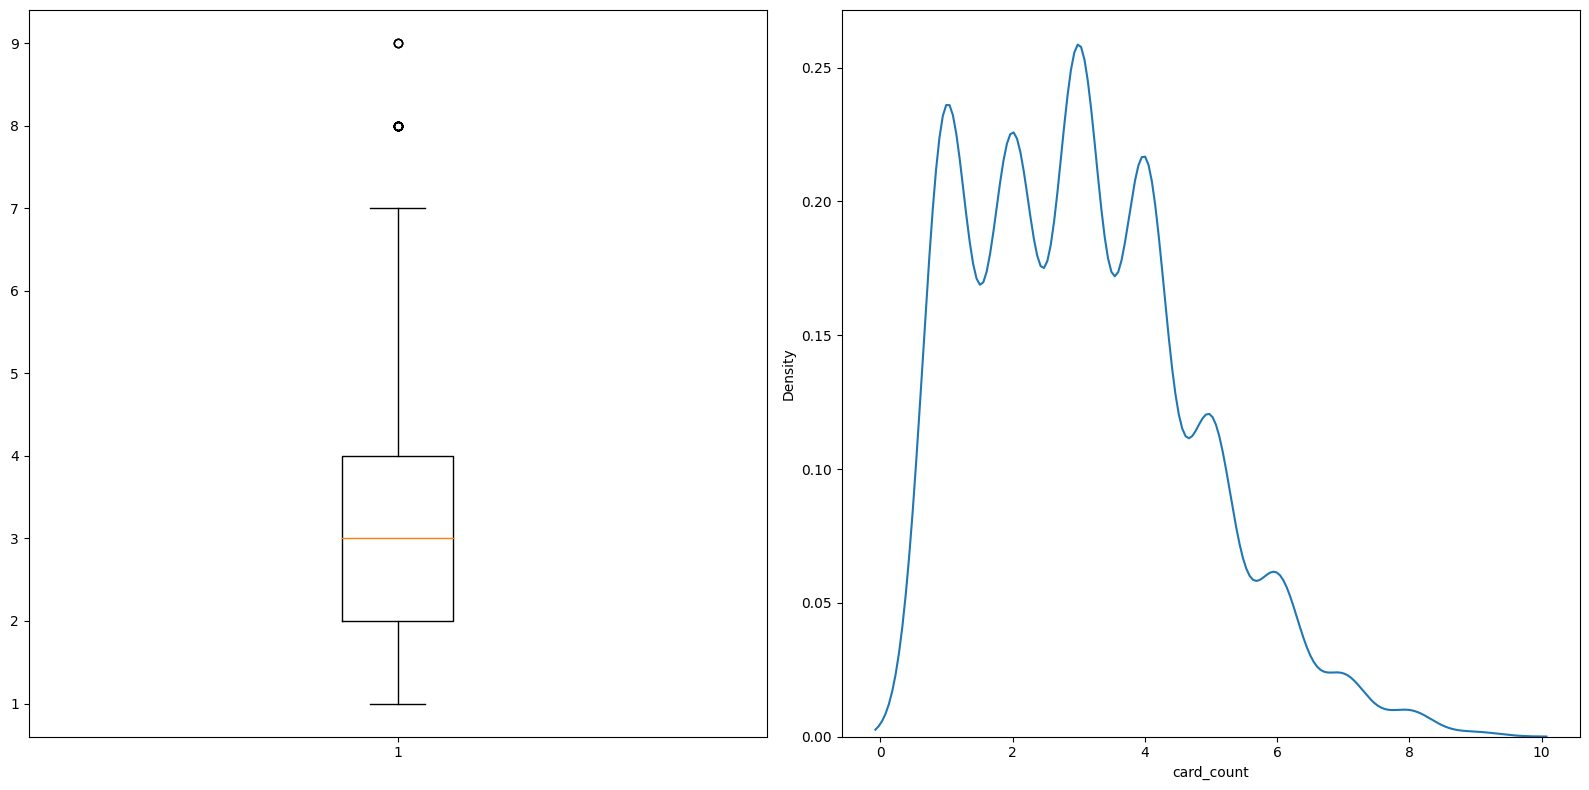

In [12]:
fig, axes = plt.subplots(1,2,figsize=(16,8))

box = axes[0].boxplot(client_df['card_count'])
# plt.title('Number of cards in each client')

kde_plot = sns.kdeplot(client_df['card_count'], ax=axes[1])
# kde_plot.set_titles('Density distribution of number of cards in each client')

plt.tight_layout()
plt.show()

The distribution of the number of cards per client shows that most clients hold multiple cards, 50% of clients own between 2 and 4 cards, suggesting that multi-card ownership is common in this dataset. The density rapidly decreases after 5 cards, implying that clients with more than five cards are rare.


### Transactions Data

**📊 Dataset Description:**
This dataset contains detailed information about **card transactions**, including transaction metadata, customer identifiers, merchant details, and transaction characteristics. The dataset includes both **positive and negative transaction amounts**, where negative values may represent refunds or reversals.

***Columns Description***

| Column Name        | Data Type  | Description |
|--------------------|------------|-------------|
| **id**              | Integer    | Unique identifier for each transaction record. |
| **date**            | Datetime   | Timestamp of the transaction (date and time when the transaction occurred). |
| **client_id**        | Integer    | Unique identifier of the customer who made the transaction. |
| **card_id**          | Integer    | Unique identifier of the credit card used in the transaction. |
| **amount**            | Float      | Transaction amount in USD, including negative values for refunds or chargebacks. |
| **use_chip**          | String     | Transaction method (Swipe Transaction, Chip Transaction, Online Transaction). |
| **merchant_id**       | Integer    | Unique identifier of the merchant where the transaction took place. |
| **merchant_city**     | String     | City where the merchant is located. |
| **merchant_state**    | String     | State or region where the merchant is located (US state abbreviation). |
| **zip**               | String     | ZIP/postal code of the merchant location. |
| **mcc**               | Integer    | Merchant Category Code (MCC), which classifies the merchant’s business type. |
| **errors**            | String     | Error or anomaly flags related to the transaction (e.g., declined, processing errors). Missing values indicate no detected errors. |


In [13]:
print(txn_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.2+ GB
None


In [14]:
txn_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [15]:
print(txn_df.shape)

# Checking null value
print(txn_df.isnull().sum())

(13305915, 12)
id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
dtype: int64


In [16]:
# Fill null value in 'errors' column with 'none'
txn_df['errors'].fillna('none', inplace=True)

C:\Users\Hoang Lan\AppData\Local\Temp\ipykernel_20628\1708868048.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  txn_df['errors'].fillna('none', inplace=True)


In [17]:
txn_df.describe(include='all')

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
count,1.330592e+07,13305915,1.330592e+07,1.330592e+07,13305915,13305915,1.330592e+07,13305915,11742215,1.165321e+07,1.330592e+07,13305915
unique,NaN,4136496,NaN,NaN,81161,3,NaN,12492,199,NaN,NaN,23
top,NaN,2011-06-09 12:46:00,NaN,NaN,$80.00,Swipe Transaction,NaN,ONLINE,CA,NaN,NaN,none
freq,NaN,18,NaN,NaN,132115,6967185,NaN,1563700,1427087,NaN,NaN,13094522
mean,1.558402e+07,NaN,1.026812e+03,3.475268e+03,NaN,NaN,4.772376e+04,NaN,NaN,5.132782e+04,5.565440e+03,NaN
std,4.704499e+06,NaN,5.816386e+02,1.674356e+03,NaN,NaN,2.581534e+04,NaN,NaN,2.940423e+04,8.757002e+02,NaN
min,7.475327e+06,NaN,0.000000e+00,0.000000e+00,NaN,NaN,1.000000e+00,NaN,NaN,1.001000e+03,1.711000e+03,NaN
25%,1.150604e+07,NaN,5.190000e+02,2.413000e+03,NaN,NaN,2.588700e+04,NaN,NaN,2.860200e+04,5.300000e+03,NaN
50%,1.557087e+07,NaN,1.070000e+03,3.584000e+03,NaN,NaN,4.592600e+04,NaN,NaN,4.767000e+04,5.499000e+03,NaN
75%,1.965361e+07,NaN,1.531000e+03,4.901000e+03,NaN,NaN,6.757000e+04,NaN,NaN,7.790100e+04,5.812000e+03,NaN


In [18]:
# Check for duplicates
print(txn_df.duplicated().sum())

0


In [19]:
check_null = pd.DataFrame(txn_df[txn_df['zip'].isnull()])
print(check_null.shape)
check_null_agg = check_null.groupby('merchant_city').agg(count=('id','nunique'))
check_null_agg.sort_values(by='count', ascending=False, inplace=True)
check_null_agg

(1652706, 12)


,count
merchant_city,
ONLINE,1563700
Cancun,9325
Rome,7081
Mexico City,5102
Cabo San Lucas,4550
...,...
Libreville,3
Honiara,3
Addis Ababa,3


We can see that all of transactions which have null value in some columns like 'merchant_state', 'zip',... They are online transactions. Some non online transactions still have null value in 'zip'. However since we don't use this columns much for analysis, I would just fill na with 'Unknown'.

In [20]:
txn_df.loc[txn_df['merchant_city']=='ONLINE','merchant_state'] = 'ONLINE'
txn_df.fillna({'zip': 'Unknown'}, inplace=True)

We also need to transform the 'amount' columns since it is categorized as string. We have to replace '$' and change the type to float for further analysis.

In [21]:
txn_df['amount'] = txn_df['amount'].str.replace('$','').astype(float)

In [22]:
# check unique values for 'use_chip'
print(txn_df['use_chip'].unique())
print(txn_df.loc[txn_df['merchant_state']=='ONLINE','use_chip'].unique())

['Swipe Transaction' 'Online Transaction' 'Chip Transaction']
['Online Transaction' 'Chip Transaction']


Some records show inconsistencies between merchant location and transaction channel (e.g., merchant_state = 'ONLINE' while use_chip indicates chip-based transactions). 
This may be due to data anonymization, synthetic data generation, or hybrid transaction scenarios where online orders are completed in physical stores. 
These inconsistencies were retained to reflect real-world data noise.

In [23]:
# check unique values for 'use_chip'
print(txn_df['errors'].unique())

['none' 'Technical Glitch' 'Bad Expiration' 'Bad Card Number'
 'Insufficient Balance' 'Bad PIN' 'Bad CVV' 'Bad Zipcode'
 'Insufficient Balance,Technical Glitch' 'Bad PIN,Insufficient Balance'
 'Bad PIN,Technical Glitch' 'Bad Expiration,Technical Glitch'
 'Bad Card Number,Bad Expiration' 'Bad Card Number,Insufficient Balance'
 'Bad Expiration,Insufficient Balance' 'Bad Card Number,Bad CVV'
 'Bad CVV,Technical Glitch' 'Bad Expiration,Bad CVV'
 'Bad CVV,Insufficient Balance' 'Bad Card Number,Technical Glitch'
 'Bad Zipcode,Insufficient Balance'
 'Bad Card Number,Bad Expiration,Insufficient Balance'
 'Bad Zipcode,Technical Glitch']


In [24]:
txn_error = txn_df.loc[txn_df['errors'] != 'none', ['id','errors']]
txn_error['errors'] = txn_error['errors'].str.split(',')
txn_error = txn_error.explode('errors')
print(txn_error.shape)

txn_error_agg = txn_error.groupby('errors').agg(count=('id','nunique')).sort_values(by='count', ascending=False).reset_index()
txn_error_agg['pct'] = (txn_error_agg['count']/ txn_error_agg['count'].sum())*100
txn_error_agg

(212335, 2)


,errors,count,pct
0,Insufficient Balance,131621,61.987426
1,Bad PIN,32482,15.297525
2,Technical Glitch,26633,12.542916
3,Bad Card Number,7925,3.732310
4,Bad Expiration,6295,2.964655
5,Bad CVV,6241,2.939223
6,Bad Zipcode,1138,0.535946


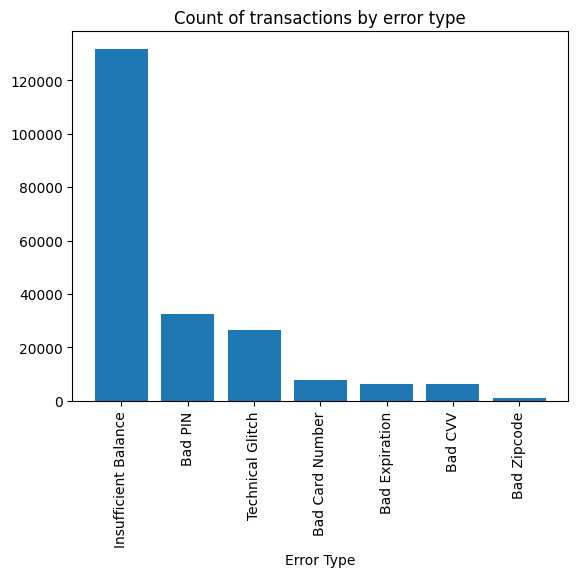

In [25]:
plt.bar(txn_error_agg['errors'], txn_error_agg['count'])
plt.title('Count of transactions by error type')
plt.xticks(rotation=90)
plt.xlabel('Error Type')
plt.show()

The bar chart and summary table show that **Insufficient Balance** is by far the most dominant error type, accounting for **131,621 transactions (≈61.99%)**. This indicates that insufficient funds is the primary reason for transaction failures, reflecting either customer financial constraints or strict real-time balance validation rules in the system.

The second most common error is **Bad PIN**, with **32,482 transactions (≈15.30%)**, followed by **Technical Glitch** with **26,633 transactions (≈12.54%)**. These errors suggest potential issues related to user authentication behavior (e.g., incorrect PIN attempts) and system stability or infrastructure reliability.


In [26]:
# Drop 'errors' column after create seperated error dataframe
txn_df.drop(columns=['errors'], inplace=True)

# Change 'date' column to datetime type
txn_df['date'] = pd.to_datetime(txn_df['date'])
print(txn_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              int64         
 1   date            datetime64[ns]
 2   client_id       int64         
 3   card_id         int64         
 4   amount          float64       
 5   use_chip        object        
 6   merchant_id     int64         
 7   merchant_city   object        
 8   merchant_state  object        
 9   zip             object        
 10  mcc             int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 1.1+ GB
None


In [27]:
print(txn_df[['amount']].describe())

             amount
count  1.330592e+07
mean   4.297604e+01
std    8.165575e+01
min   -5.000000e+02
25%    8.930000e+00
50%    2.899000e+01
75%    6.371000e+01
max    6.820200e+03


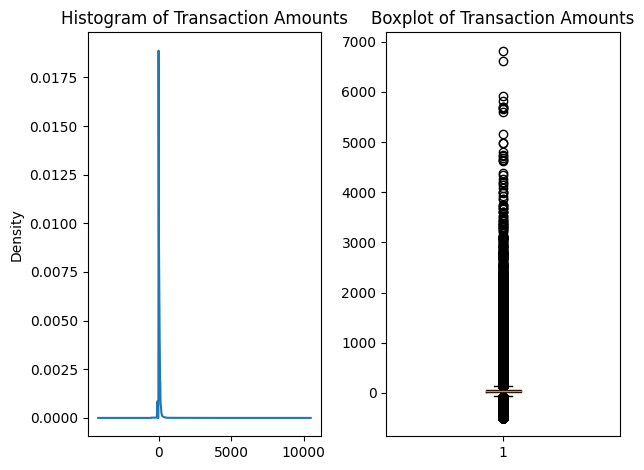

In [28]:
plt.subplot(1,2,1)
txn_df['amount'].plot(kind='kde')
plt.title('Histogram of Transaction Amounts')

plt.subplot(1,2,2)
plt.boxplot(txn_df['amount'])
plt.title('Boxplot of Transaction Amounts')

plt.tight_layout()
plt.show()

In [29]:
txn_df.loc[txn_df['amount'] <0]

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc
0,7475327,2010-01-01 00:01:00,1556,2972,-77.0,Swipe Transaction,59935,Beulah,ND,58523.0,5499
19,7475347,2010-01-01 00:36:00,114,3398,-64.0,Swipe Transaction,61195,North Hollywood,CA,91606.0,5541
50,7475382,2010-01-01 01:25:00,1703,2969,-78.0,Swipe Transaction,43293,Grand Junction,CO,81506.0,5499
81,7475422,2010-01-01 02:13:00,1453,1117,-460.0,Swipe Transaction,5009,Middletown,NY,10940.0,7011
114,7475460,2010-01-01 03:08:00,957,4532,-147.0,Swipe Transaction,44795,Marysville,OH,43040.0,3780
...,...,...,...,...,...,...,...,...,...,...,...
13305780,23761706,2019-10-31 22:13:00,1360,143,-91.0,Chip Transaction,59935,Crestview,FL,32536.0,5499
13305811,23761745,2019-10-31 22:28:00,194,5587,-71.0,Swipe Transaction,59935,Hartford City,IN,47348.0,5499
13305813,23761747,2019-10-31 22:29:00,133,4683,-52.0,Chip Transaction,61195,Marietta,GA,30067.0,5541
13305820,23761757,2019-10-31 22:35:00,260,323,-77.0,Chip Transaction,22204,Mission,TX,78572.0,5541


From the histogram and boxplot, ***transaction amounts*** exhibit a highly **right-skewed distribution**. Most transactions are concentrated at very low values, indicating that users mainly perform small daily purchases. However, there is a long right tail with several extreme high-value transactions, reaching up to around 10,000, which are considered outliers. Handling outliers and negative values is necessary before applying statistical or machine learning models.

The boxplot further confirms this pattern, showing a small interquartile range (IQR) and a low median, while numerous outliers appear on the upper side. Additionally, a few negative values are observed, which may represent refunds, chargebacks, or data inconsistencies.



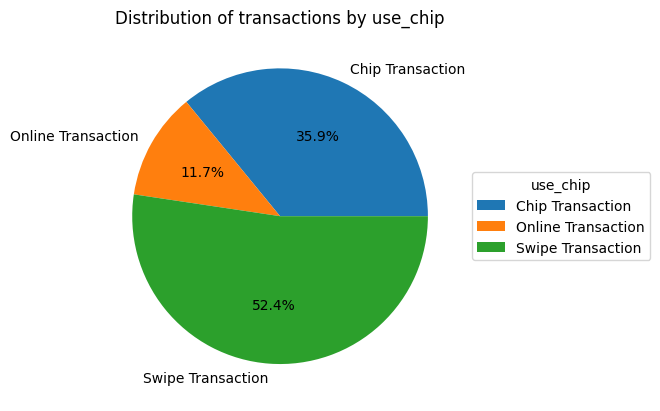

In [30]:
use_chip_df = pd.DataFrame(txn_df.groupby('use_chip').agg(count=('id','nunique'))).reset_index()

plt.pie(use_chip_df['count'], labels=use_chip_df['use_chip'], autopct='%1.1f%%')
plt.title('Distribution of transactions by use_chip')
plt.legend(title='use_chip', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

count     1219.000000
mean     10915.434783
std       5607.355367
min        760.000000
25%       7223.500000
50%       9832.000000
75%      13349.000000
max      48479.000000
Name: txn_count, dtype: float64


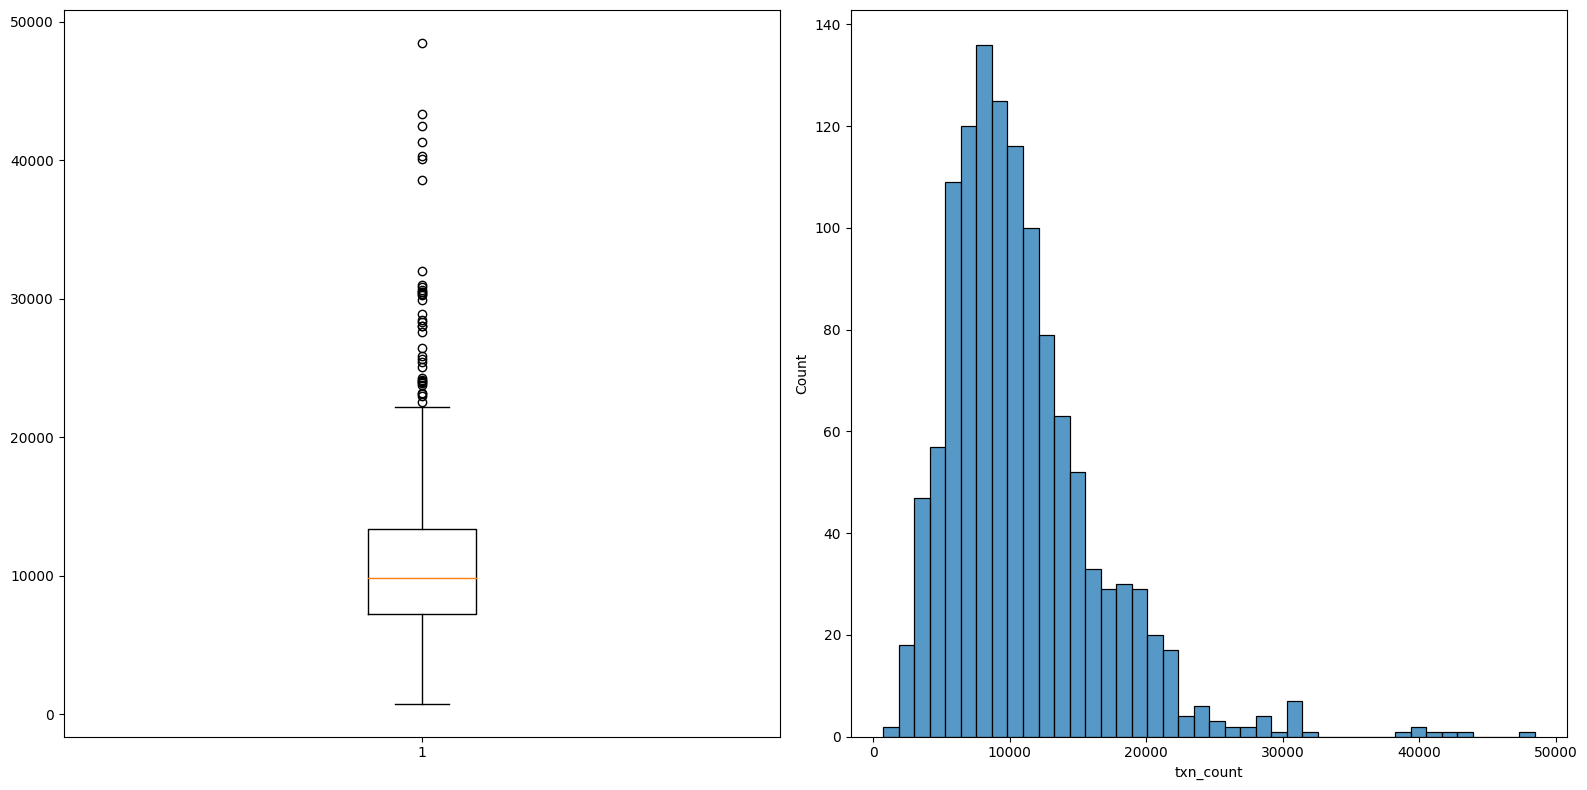

In [31]:
txn_client_df = pd.DataFrame(txn_df.groupby('client_id').agg(txn_count=('id','nunique'))).reset_index()
print(txn_client_df['txn_count'].describe())

fig, axes = plt.subplots(1,2,figsize=(16,8))
box = axes[0].boxplot(txn_client_df['txn_count'])
kde_plot = sns.histplot(txn_client_df['txn_count'], ax=axes[1])
plt.tight_layout() 

The distribution is **right-skewed**, indicating that most clients have a moderate number of transactions, while a small subset of clients generate an exceptionally high transaction volume, highlighting highly active or potentially automated users.

### Users Dataset

**📊 Dataset Description:**
This dataset contains **demographic, geographic, and financial information about credit card clients**. It provides insights into customer profiles, income levels, debt status, creditworthiness, and card ownership, which are useful for customer segmentation, risk analysis, and financial behavior modeling.

***Columns Description***

| Column Name | Data Type | Description |
|-------------|-----------|-------------|
| **id** | Integer | Unique identifier for each client. |
| **current_age** | Integer | Current age of the client. |
| **retirement_age** | Integer | Expected retirement age of the client. |
| **birth_year** | Integer | Year of birth of the client. |
| **birth_month** | Integer | Month of birth of the client (1–12). |
| **gender** | String | Gender of the client (e.g., Male, Female). |
| **address** | String | Residential address of the client. |
| **latitude** | Float | Latitude coordinate of the client’s residence. |
| **longitude** | Float | Longitude coordinate of the client’s residence. |
| **per_capita_income** | String | Income per person in the household, stored as a currency string. |
| **yearly_income** | String | Annual income of the client, stored as a currency string. |
| **total_debt** | String | Total outstanding debt of the client, stored as a currency string. |
| **credit_score** | Integer | Credit score indicating the client’s creditworthiness. Higher scores represent lower credit risk. |
| **num_credit_cards** | Integer | Number of credit cards owned by the client. |


In [32]:
# Checking data shape
print(f"Dataframe's shape: {user_df.shape}")

# Check data type
print(user_df.info())

# Check duplicats
print(f"Number of duplicated rows:{user_df.duplicated().sum()}")

print('_'*50)

user_df.head()


Dataframe's shape: (2000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   object 
 10  yearly_income      2000 non-null   object 
 11  total_debt         2000 non-null   object 
 12  credit_score       2000 non-null   int64  
 13  num_credit_cards   2000 non-null   int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 218.9+ KB
None
Number of duplicated rows:

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


In [33]:
# Check for null values
null_counts = user_df.isnull().sum()

In [34]:
# Transform Income and debt variables to numeric type
income_df = ['per_capita_income', 'yearly_income', 'total_debt']

for i in income_df:
 user_df[i] = user_df[i].str.replace("$","").astype("float")

In [35]:
user_df.describe(include='all')

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000,2000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
unique,NaN,NaN,NaN,NaN,NaN,2,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Female,506 Washington Lane,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,1016,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,999.500000,45.391500,66.237500,1973.803000,6.439000,NaN,NaN,37.389225,-91.554765,23141.928000,45715.882000,63709.694000,709.734500,3.073000
std,577.494589,18.414092,3.628867,18.421234,3.565338,NaN,NaN,5.114324,16.283293,11324.137358,22992.615456,52254.453421,67.221949,1.637379
min,0.000000,18.000000,50.000000,1918.000000,1.000000,NaN,NaN,20.880000,-159.410000,0.000000,1.000000,0.000000,480.000000,1.000000
25%,499.750000,30.000000,65.000000,1961.000000,3.000000,NaN,NaN,33.837500,-97.395000,16824.500000,32818.500000,23986.750000,681.000000,2.000000
50%,999.500000,44.000000,66.000000,1975.000000,7.000000,NaN,NaN,38.250000,-86.440000,20581.000000,40744.500000,58251.000000,711.500000,3.000000
75%,1499.250000,58.000000,68.000000,1989.000000,10.000000,NaN,NaN,41.200000,-80.130000,26286.000000,52698.500000,89070.500000,753.000000,4.000000


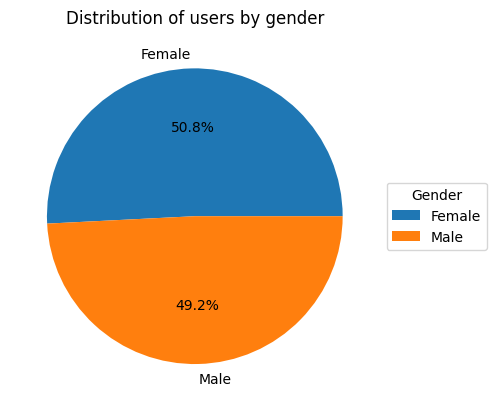

In [36]:
gender_df = pd.DataFrame(user_df.groupby('gender')['id'].nunique()).reset_index()

plt.pie(gender_df['id'], labels=gender_df['gender'], autopct='%1.1f%%')
plt.title('Distribution of users by gender')
plt.legend(title='Gender', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [40]:
birth_year_counts = pd.DataFrame(user_df.groupby('birth_year')['id'].nunique()).reset_index()
birth_year_counts

,birth_year,id
0,1918,1
1,1920,1
2,1921,2
3,1926,3
4,1927,4
...,...,...
75,1998,47
76,1999,36
77,2000,35
78,2001,40


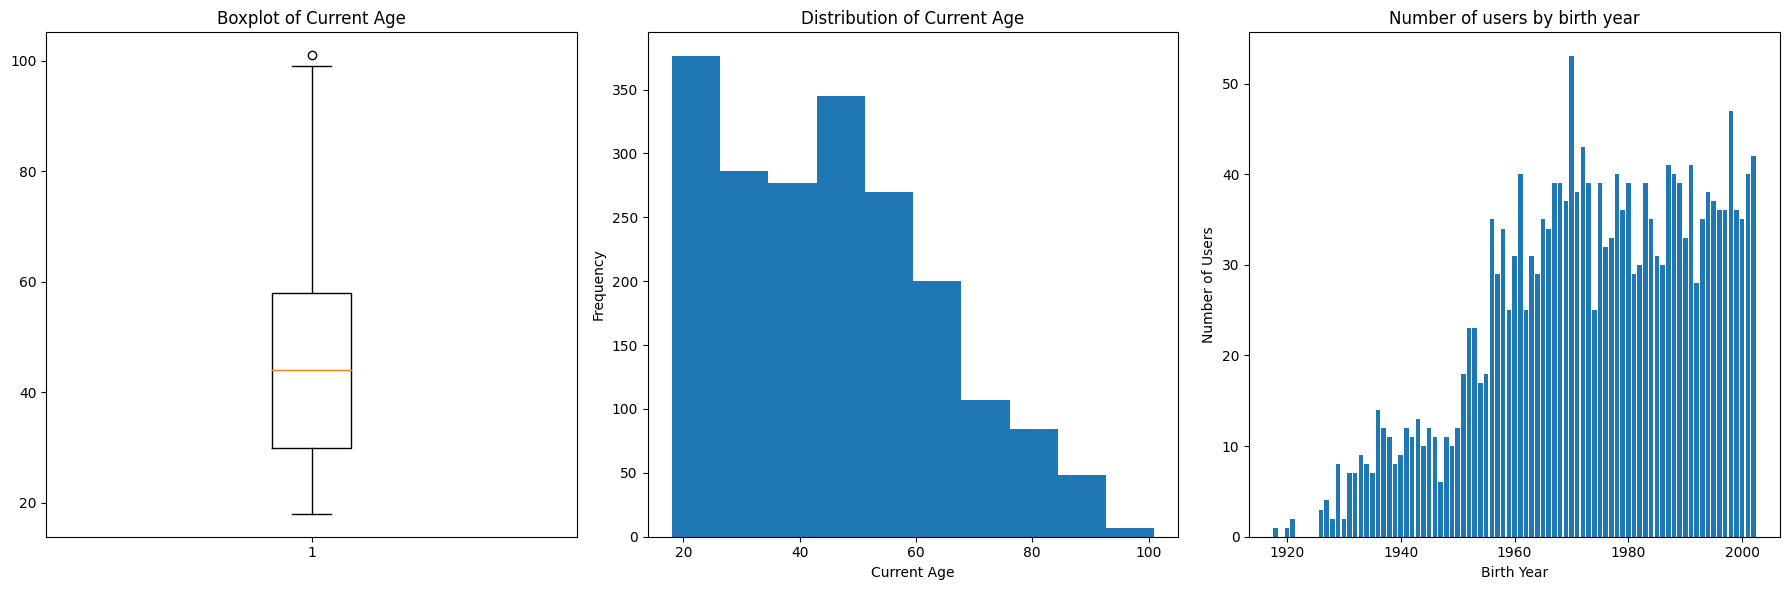

In [41]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.boxplot(user_df['current_age'])
plt.title('Boxplot of Current Age')

plt.subplot(1,3,2)
plt.hist(user_df['current_age'])
plt.title('Distribution of Current Age')
plt.xlabel('Current Age')
plt.ylabel('Frequency')

plt.subplot(1,3,3)
plt.bar(birth_year_counts['birth_year'], birth_year_counts['id'])
plt.title('Number of users by birth year')
plt.xlabel('Birth Year')
plt.ylabel('Number of Users')

plt.tight_layout()
plt.show()

The boxplot and histogram show that the **current age of clients ranges widely from young adults to elderly individuals**, with most users concentrated in the middle-age group. The median age is approximately in the **early 40s**, with an interquartile range roughly between **30 and 55 years**, indicating that the majority of clients are middle-aged.

The age distribution is moderately right-skewed, with fewer very young and very old users. Several outliers above **90 years old** are observed, which may represent elderly clients or potential data quality issues that should be validated.

The birth year distribution indicates that most users were born between **1950 and 1990**, suggesting that the dataset primarily consists of users from the Baby Boomer and Generation X cohorts. The number of users decreases significantly for very old birth years, reflecting natural population aging effects and potential data sparsity in older cohorts.

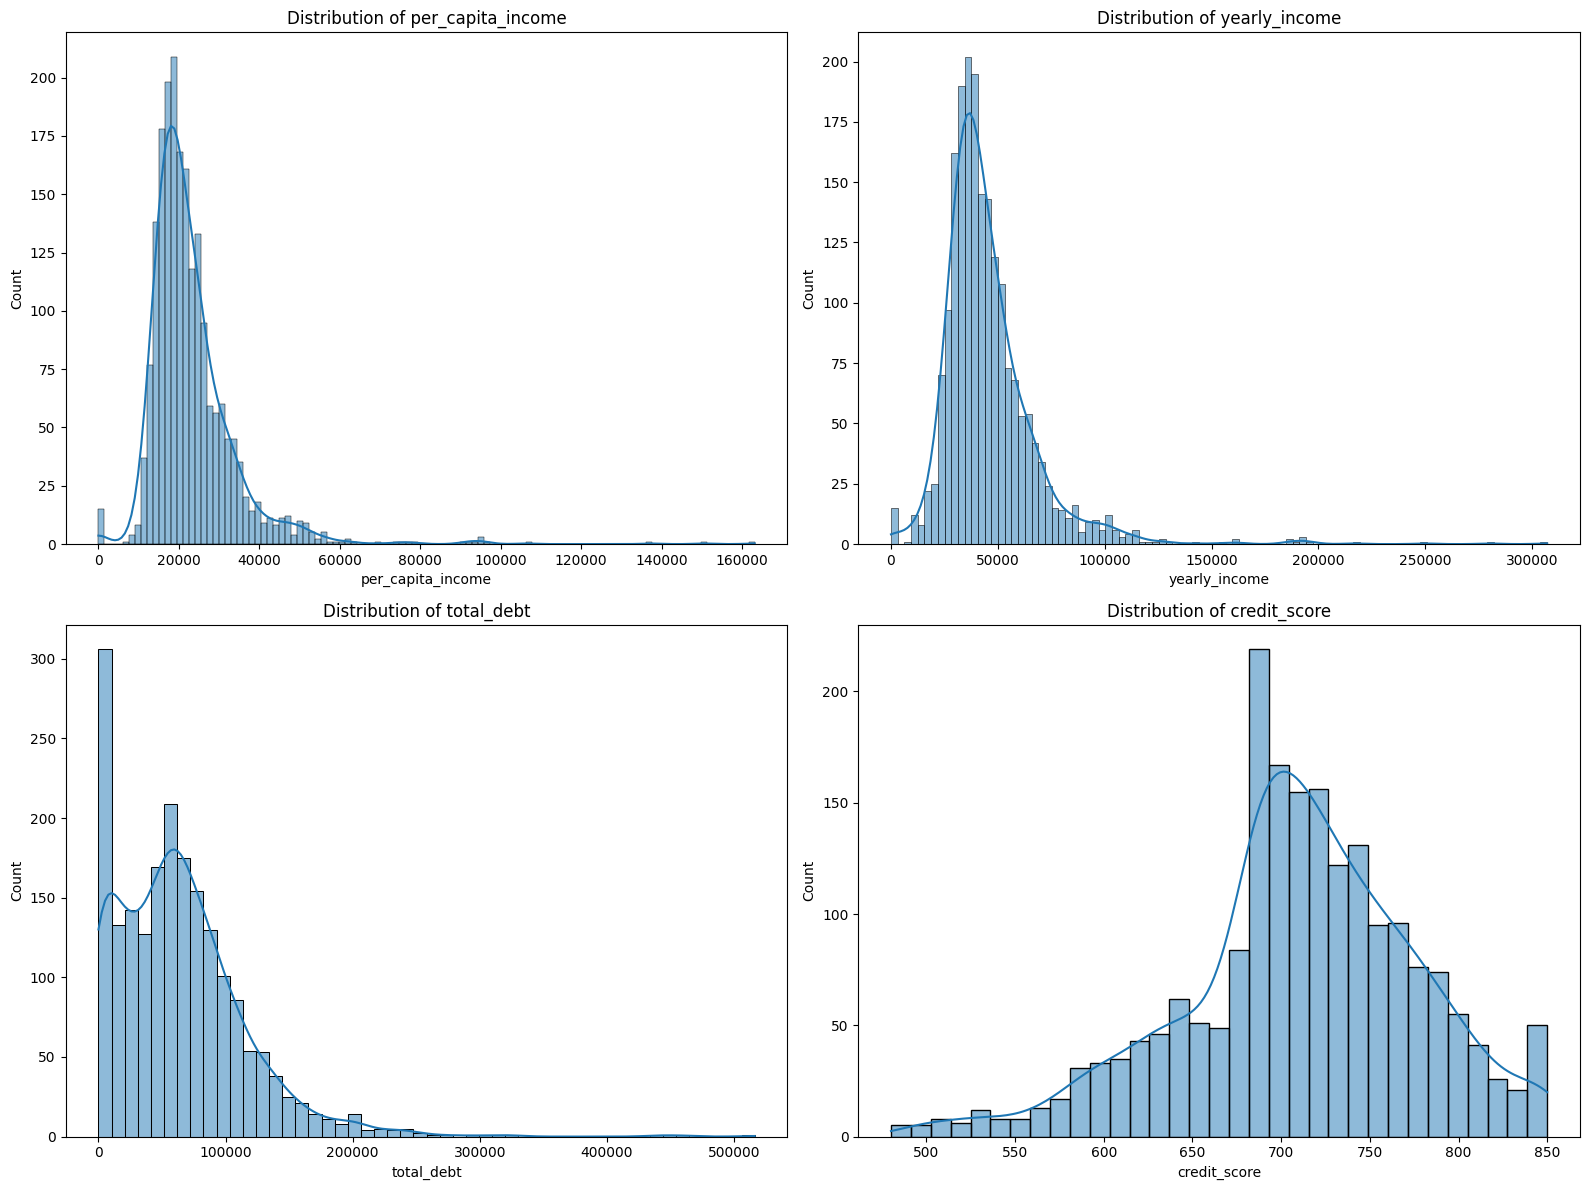

In [57]:
# Distributions
fig, axes = plt.subplots(2,2, figsize=(16,12))

df = ['per_capita_income', 'yearly_income', 'total_debt', 'credit_score']
for i, col in enumerate(df):
    row = i // 2
    col_idx = i % 2
    sns.histplot(user_df[col], kde=True, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


In [43]:
user_df.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,37891.0,77254.0,191349.0,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,22681.0,33483.0,196.0,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,163145.0,249925.0,202328.0,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,53797.0,109687.0,183855.0,675,1


In [62]:
for i, col in enumerate(df):
    print(i, col)
    print(i//2)

0 per_capita_income
0
1 yearly_income
0
2 total_debt
1
3 credit_score
1


C:\Users\Hoang Lan\AppData\Local\Temp\ipykernel_20628\2060176773.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=user_df['gender'], y=user_df['current_age'], palette='Set3')


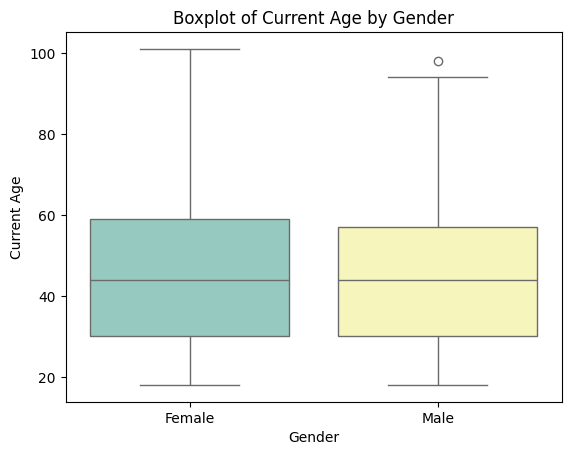

In [55]:
sns.boxplot(x=user_df['gender'], y=user_df['current_age'], palette='Set3')
plt.xlabel('Gender')
plt.ylabel('Current Age')
plt.title('Boxplot of Current Age by Gender')
plt.show()

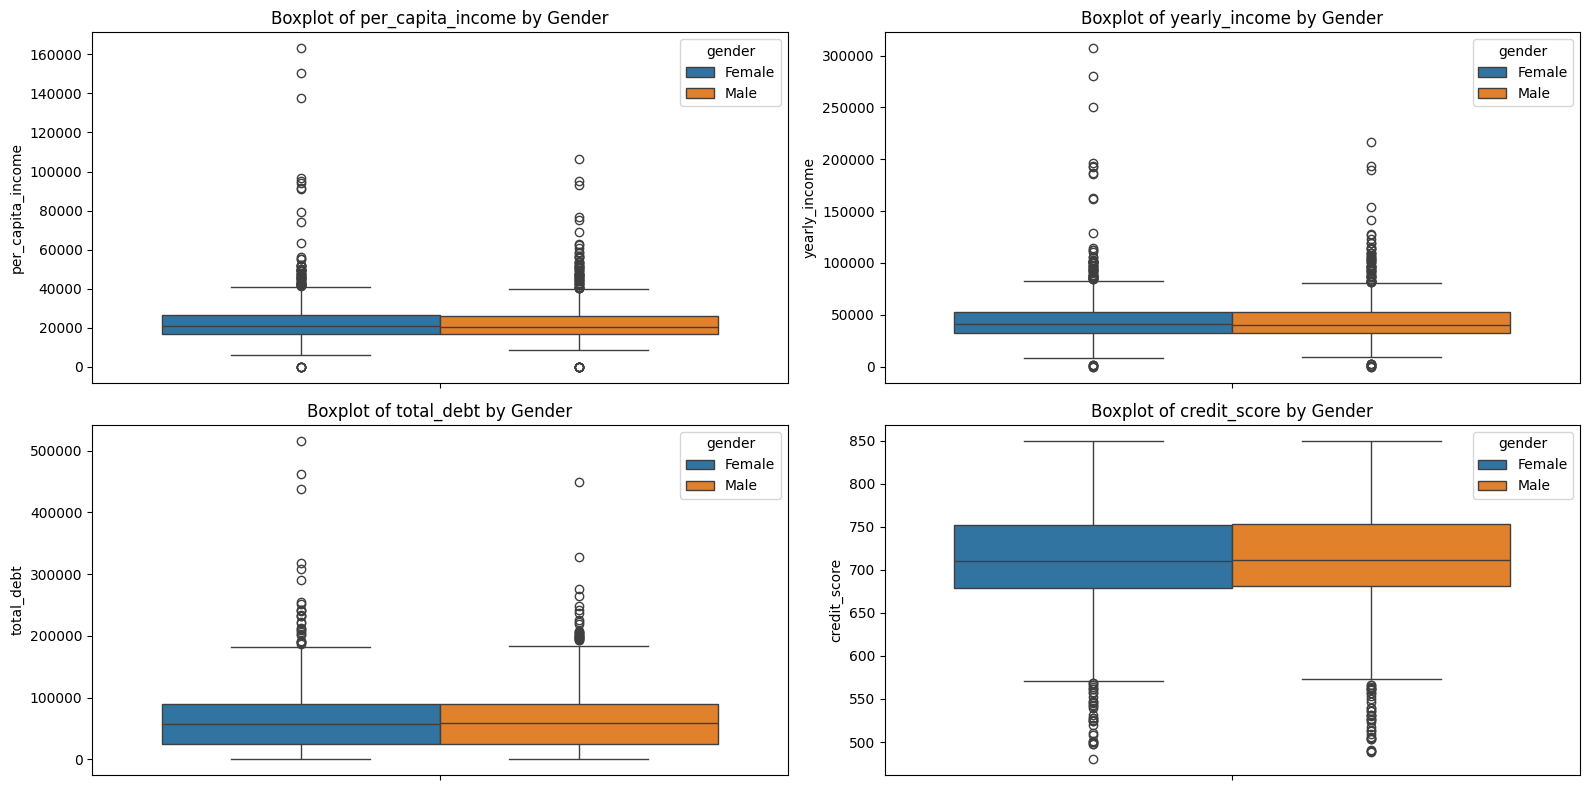

In [68]:
fig, axes = plt.subplots(2,2, figsize=(16,8))

for i, col in enumerate(df):
    col_index = i % 2
    row = i // 2
    sns.boxplot(y=user_df[col], ax=axes[row,col_index], hue=user_df['gender'])
    axes[row,col_index].set_title(f'Boxplot of {col} by Gender')

plt.tight_layout()
plt.show()

The boxplots show that income, total debt, credit score, and age distributions are highly similar between males and females. The medians and interquartile ranges largely overlap across all variables. Although both groups exhibit right-skewness and several high-value outliers (especially for income and debt), no clear gender-based disparity is observed. Overall, the dataset appears ***gender-balanced*** from a descriptive perspective.


### MCC Codes

In [ ]:
print(mcc_codes_df.shape)

print(mcc_codes_df.isnull().sum())

mcc_codes_df

(109, 2)
mcc_code       0
description    0
dtype: int64


,mcc_code,description
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees
...,...,...
104,7549,Towing Services
105,5941,Sporting Goods Stores
106,5722,Household Appliance Stores
107,3009,Fabricated Structural Metal Products


### Fraud labeling

In [ ]:
fraud_label_df.head()

,transaction_id,fraud_label
0,10649266,No
1,23410063,No
2,9316588,No
3,12478022,No
4,9558530,No


In [ ]:
print(fraud_label_df.shape)

print(fraud_label_df.isnull().sum())

(8914963, 2)
transaction_id    0
fraud_label       0
dtype: int64


# Export data as csv for Power BI

In [ ]:
# cards_df.to_csv("C:/Users/Hoang Lan/OneDrive/Máy tính/Project/FinancialTransactionsAnalysis/transformed_data/cards_data.csv", index=False)
# txn_df.to_csv("C:/Users/Hoang Lan/OneDrive/Máy tính/Project/FinancialTransactionsAnalysis/transformed_data/transactions_data.csv", index=False)
# txn_error.to_csv("C:/Users/Hoang Lan/OneDrive/Máy tính/Project/FinancialTransactionsAnalysis/transformed_data/transaction_errors.csv", index=False)
# user_df.to_csv("C:/Users/Hoang Lan/OneDrive/Máy tính/Project/FinancialTransactionsAnalysis/transformed_data/users_data.csv", index=False)
# mcc_codes_df.to_csv("C:/Users/Hoang Lan/OneDrive/Máy tính/Project/FinancialTransactionsAnalysis/transformed_data/mcc_codes.csv", index=False)
# fraud_label_df.to_csv("C:/Users/Hoang Lan/OneDrive/Máy tính/Project/FinancialTransactionsAnalysis/transformed_data/fraud_labels.csv", index=False)